# Data Analysis 2025

## Chapter VI: Regularization

### Learning goals

- (Apply cross-validation (CV) (and K-fold CV) to your models)
- Explain the concepts of over/under-fitting and the bias/variance trade-off
- Assess when a model is leaning towards overfitting
- Explain the concept of regularization and the need for it
- Apply regularization in supervised learning models
- Discuss evaluation of your developed model in terms of robustness
- Propose ways to assess robustness of your model on the basis of your dataset and task

Up to now, we have been looking at various types of supervised learning algorithms, namely regression and classification.

We also saw how to evaluate these algorithms in terms of performance metrics and we discussed the concepts of bias/variance.

We will discuss how models fail because of high bias and/or high variance and introduce *regularization* as a general technique to address these issues.

# Part 1: Two Failure Cases of Supervised Learning

Let's start this process by examining more closely an algorithm we have introduced in earlier lectures---polynomial regression. We will see some setting where supervised learning works well, and two settings where it does not.

## Review of Polynomial Regression

Recall that in (1D) polynomial regression, we fit a model
$$ f_\theta(x) := \theta^\top \phi(x) = \sum_{j=0}^p \theta_j x^j =
\theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + ...$$
<br>
that is linear in $\theta$ but non-linear in $x$ because the features 
$$\phi(x) = [1\; x\; \ldots\; x^p]$$ 
are non-linear. Using these features, we can fit any polynomial of degree $p$. Because the model is linear in the weights $\theta$, we can use the normal equations to find the $\theta$ that minimizes the mean squared error and has the best model fit. However, the resulting model can still be highly non-linear in $x$.

### Case 1: Polynomials Fit the Data Well

When we switch from linear models to polynomials, we can better fit the data and increase the accuracy of our models. This is not surprising---a polynomial is more flexible than a linear function.

Let's illustrate polynomial regression by implementing it on a toy dataset, in which we are trying to fit a cosine function.

First, we need to generate the dataset. We will do that by first defining our cosine function.

In [1]:
import numpy as np
np.random.seed(0)

def true_fn(X):
    return np.cos(1.5 * np.pi * X)

Let's visualize it.

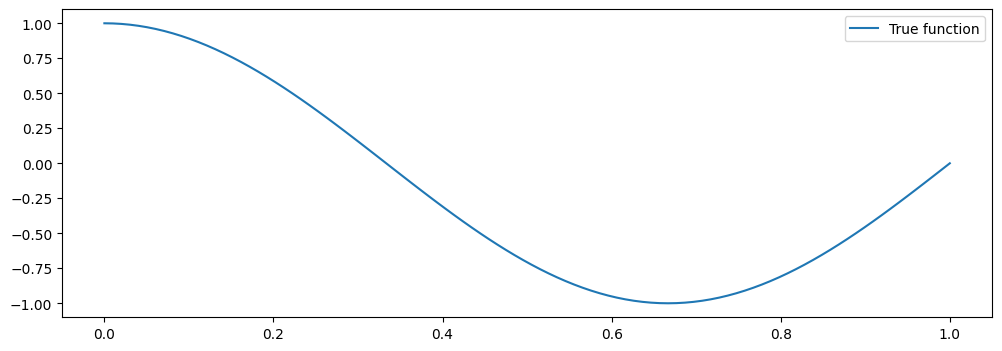

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.legend()

Let's now generate datapoints around that function. We will generate random $x$, and then generate random $y$ using
$$ y = f(x) + \epsilon $$
where $f$ is our true cosine function and $\epsilon$ is a random noise variable.

In [3]:
n_samples = 30

X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

We can visualize the samples.

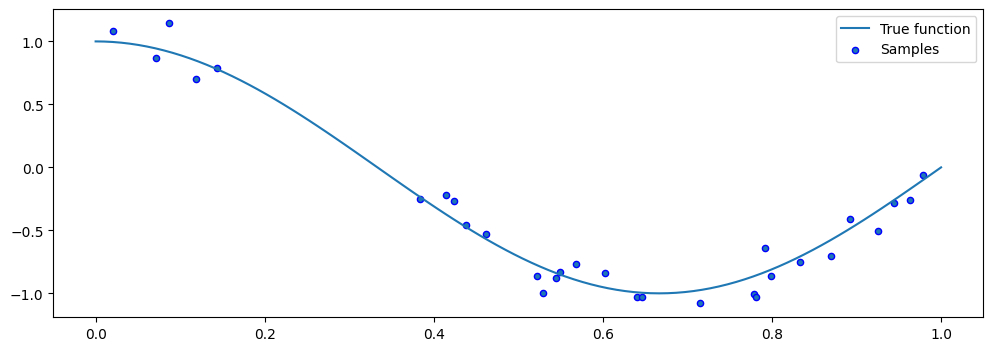

In [4]:
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.legend()

These samples give us our dataset. We can now try to fit it using a number of different models, including linear functions and polynomials of various degrees. Although fitting a linear model does not work well, quadratic or cubic polynomials improve the fit.

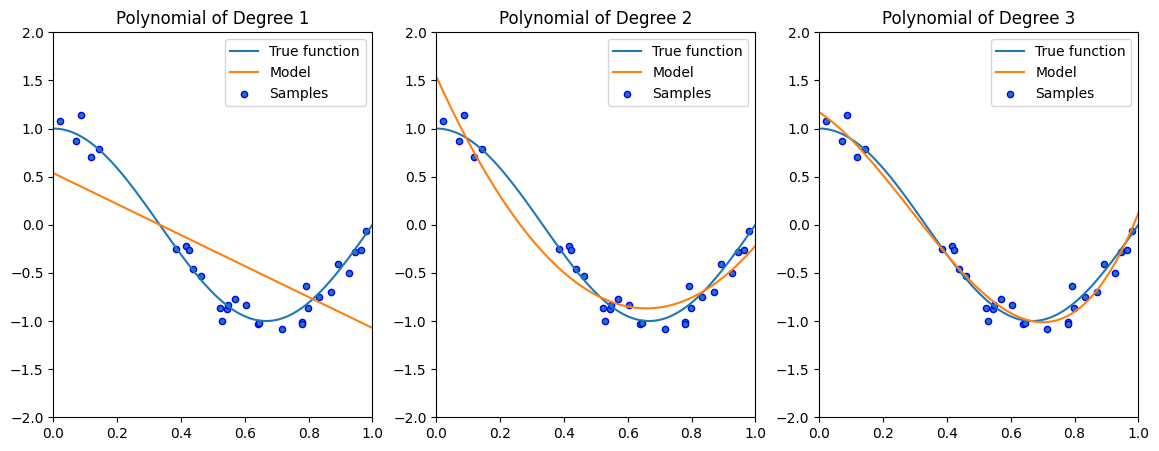

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


degrees = [1, 2, 3]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

### Case 2: Towards Higher-Degree Polynomial Features?

As we increase the complexity of our model class $\mathcal{M}$ to include even higher degree polynomials, we are able to fit the data even better.

What happens if we further increase the degree of the polynomial?

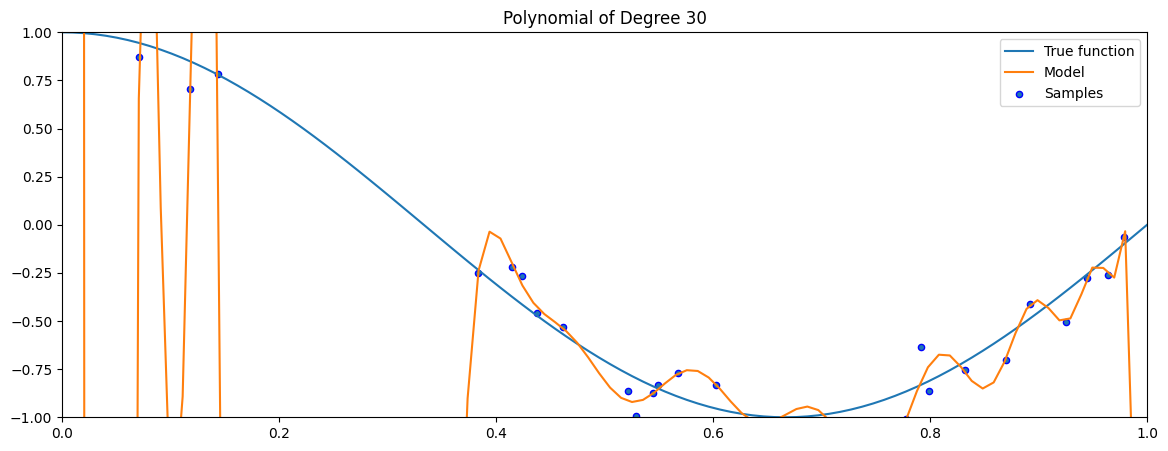

In [6]:
degrees = [30]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 1, 100)
    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-1, 1))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

As the degree of the polynomial increases to the size of the dataset, we are increasingly able to fit every point in the dataset.

However, this results in a highly irregular curve: its behavior outside the training set is wildly inaccurate!

## Overfitting and Underfitting

We have seen above a clear failure of polynomial regression. In fact, this failure represents an example of a more general phenomenon that we call *overfitting*. Overfitting---and its opposite, underfitting---represent the most important practical failure mode of all types of supervised learning algorithms.

### Definitions

#### Overfitting

Overfitting is one of the most common failure modes of machine learning.

* A very expressive model (e.g., a high degree polynomial) fits the training dataset perfectly.
* But the model makes highly incorrect predictions outside this dataset, and doesn't generalize.

In other words, if the model is too expressive (like a high degree polynomial), we are going to fit the training dataset perfectly; however, the model will make wildly incorrect prediction at points right outside this dataset, and will also not generalize well to unseen data.

Overfitting corresponds to a low bias (i capture the training data very well) and high variance (slight changes in the training dataset mess the model).

#### Underfitting

A related failure mode is underfitting.

* A small model (e.g. a straight line), will not fit the training data well.
* Therefore, it will also not be accurate on new data.

If the model is too small (like the linear model in the above example), it will not generalize well to unseen data because it is not sufficiently complex to fit the true structure of the dataset.

Finding the tradeoff between overfitting and underfitting is one of the main challenges in applying machine learning.

Underfitting corresponds to a high bias (big training errors) and low variance (the model is flexible enough to behave similarly in slightly changed training data).

### Overfitting vs. Underfitting: Evaluation

We can diagnose overfitting and underfitting by measuring performance on a separate held out dataset (development or validation set).
* If training performance is high but holdout performance is low, we are overfitting.
* If training performance is low but holdout performance is low, we are underfitting.

Let's look at this via an example. Below, we are generating a separate held-out dataset from the same data generating process (represented via red dots on the figures). We fit three different models (the orange curves) to our training set (the blue dots), and observe their performance.

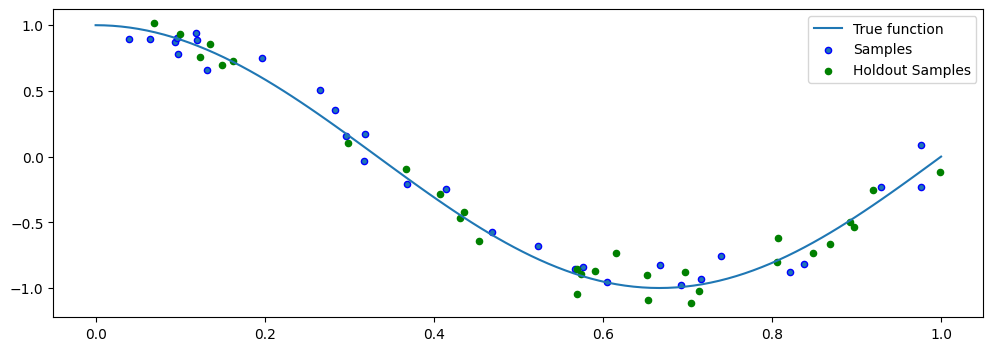

In [7]:
#Let's generate a holdout dataset for the example we saw earlier.

n_samples, n_holdout_samples = 30, 30

X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1
X_holdout = np.sort(np.random.rand(n_holdout_samples))
y_holdout = true_fn(X_holdout) + np.random.randn(n_holdout_samples) * 0.1

plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.scatter(X_holdout, y_holdout, color='g', edgecolor='g', s=20, label="Holdout Samples")
plt.legend()

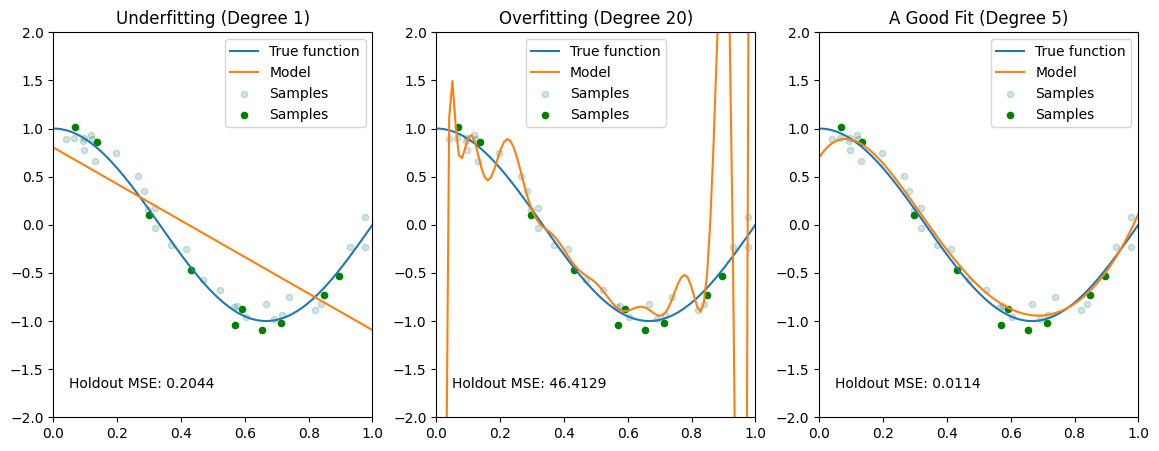

In [8]:
degrees = [1, 20, 5]
titles = ['Underfitting', 'Overfitting', 'A Good Fit']
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='g', s=20, label="Samples", alpha=0.2)
    ax.scatter(X_holdout[::3], y_holdout[::3], color='g', edgecolor='g', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("{} (Degree {})".format(titles[i], degrees[i]))
    ax.text(0.05,-1.7, 'Holdout MSE: %.4f' % ((y_holdout-pipeline.predict(X_holdout[:, np.newaxis]))**2).mean())

In the above example, the linear model is clearly too simple to fit the cosine function. It has an MSE of 0.2060 on the red held-out set. The middle model is clearly overfitting and gets a massive MSE on the red dots. The right-most figure is clearly the best fit, and it gets the lowest MSE by far.

Thus, we can detect overfitting and underfitting quantitatively by measuring performance on held out data. We will come back to this later.

### How to Fix Overfitting and Underfitting

What if our model doesn't fit the training set well? You may try the following:

* Create richer features that will make the dataset easier to fit.
* Use a more expressive model family (neural nets vs. linear models). A more expressive model is more likely to fit the data well.
* Try a better optimization procedure. Sometimes the fit is bad simply because we haven't trained our model sufficiently well.

We will also see many ways of dealing with overfitting, but here are some ideas:

* Use a simpler model family (linear models vs. neural nets)
* Keep the same model, but collect more training data. Given a model family, it will be difficult to find a highly fitting model if the dataset is very large.
* Modify the training process to penalize overly complex models. Regularization is one way to do it!

# Part 2: A Framework for Applying Supervised Learning

We have just seen that supervised learning algorithms can fail in practice. In particular they have two clear failure modes---overfitting and underfitting. In order to avoid these failures, the first step is to understand how to evaluate supervised models in a principled way. In previous classes, we developed the notions of training, validation (or development) set and test set. 

## Datasets for Model Development

When developing machine learning models, it is customary to work with three datasets:

* __Training set__: Data on which we train our algorithms.
* __Validation set__ (development or holdout set): Data used for tuning algorithms.
* __Test set__: Data used to evaluate the final performance of the model.


The test set is best thought of as a small amount of data that is put aside and never used during model development---we only use it to evaluate our final model. This is in order to not bias the development of the model towards something that would look overly favorable on the training set.

The development set on the other hand is constantly used for tasks such as hyperparameter selection.

## Model Development Workflow

The typical way in which these datasets are used is:
1. __Training:__ Try a new model and fit it on the training set.

2. __Model Selection__: Estimate performance on the development set using metrics. Based on results, try a new model idea in step #1.

I can also consider K-fold cross-validation (check slides of Chapter IV)

3. __Evaluation__: Finally, estimate real-world performance on test set.

When we start developing a new supervised learning model we often only have a rough guess as to what a good solution looks like. We start with this guess---this includes a choice of model family, features, etc.---and train it on the training set.

We then take our trained model and evaluate it on the development set. Typically, our initial guess will be bad---it may overfit, underfit, or have other types of problems. However, by observing its failure modes on the development set, we can determine which changes we need to make. For example, if we see that our model is overfitting, we know we need to make it simpler.

Thus, we take our next best guess about the model (e.g., new features or a new model family) and retrain it. After a while, we will eventually fix the problems observed on the development set.

Once we are satisfied with development set performance, we evaluate the model on the test set. This represents our final unbiased estimate of performance before we release the model into the world.

More details on K-fold cross-validation in slides of Chapter IV

# Part 3: L2 Regularization

Thus far, we have identified two common failure modes of supervised learning algorithms (overfitting and underfitting), and we have explained how to evaluate models to detect these failure modes.

Let's now look at a technique that helps avoid overfitting altogether.

#### Review: Overfitting

Recall that overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset, and doesn't generalize.

We can visualize overfitting by trying to fit a small dataset with a high degree polynomial.

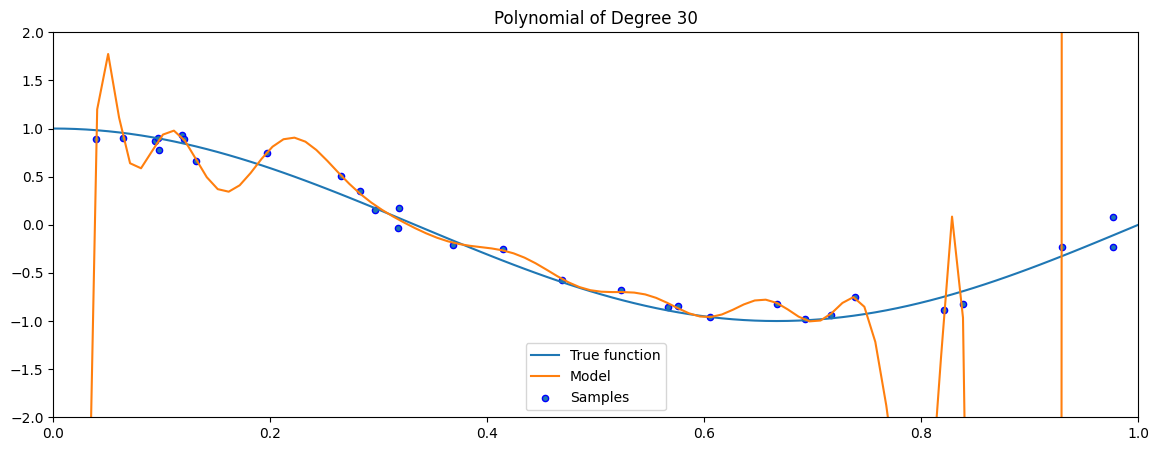

In [9]:
degrees = [30]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 1, 100)
    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

In this example, the polynomial passes through every training set points, but its fit is very bad outside the small training set.

## What is Regularization 

Intuitively, the idea of regularization is to penalize complex models that may overfit the data.

In the example with the polynomial, a less complex would rely less on polynomial terms of high degree.

### Definition

More formally, the idea of regularization is to train models with an augmented objective $J : \mathcal{M} \to \mathbb{R}$ defined over a training dataset $\mathcal{D}$ of size $n$ as

$$J(f) = \underbrace{\frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f(x^{(i)}))}_\text{Learning Objective} + \underbrace{\lambda \cdot R(f)}_\text{New Regularization Term}$$

Let's dissect this objective. It features three important components:

* A loss function $L(y, f(x))$ such as the mean squared error. This can be thought of as a standard supervised learning loss.

* A regularizer $R : \mathcal{M} \to \mathbb{R}$ that penalizes models that are overly complex. Specifically, this term takes in a function and outputs a large score for models that it considers being overly complex.

* A regularization parameter $\lambda > 0$, which controls the strength of the regularizer.

When the model $f_\theta$ is parametrized by parameters $\theta$, we also use the following notation:

$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f_\theta(x^{(i)})) + \lambda \cdot R(\theta).$$

Next, let's see some examples of what a regularizer could look like.

## L2 Regularization

How can we define a regularizer $R: \mathcal{M} \to \mathbb{R}$ to control the complexity of a model $f \in \mathcal{M}$?

In the context of linear models $f_\theta(x) = \theta^\top x$, a widely used approach is called *L2 regularization*.

### Definition

L2 regularization defines the following objective:
$$J(\theta) = \frac{1}{2n} \sum_{i=1}^n \left( y^{(i)} - \theta^\top x^{(i)} \right)^2 \cdot ||\theta||_2^2.$$

Let's dissect the components of this objective.

Note that the regularizer $R : \Theta \to \mathbb{R}$ is the function 
$R(\theta) = ||\theta||_2^2 = \sum_{j=1}^d \theta_j^2.$ 
This is also known as the L2 norm of $\theta$.

The regularizer penalizes large parameters. This prevents us from relying on any single feature and penalizes very irregular solutions.

It is an empirical fact that models that tend to overfit (like the polynomials in our examples) tend to have weights with a very large L2 norm. By penalizing this norm, we are penalizing complex models.

Finally, note that although we just defined L2 regularization in the context of linear regression, any model that has parameters can be regularized by adding to the objective the L2 norm of these parameters. Thus, the technique can be used with logistic regression, neural networks, and many other models.

### L2 Regularization for Polynomial Regression

Let's consider an application to the polynomial model we have seen so far. Given polynomial features $\phi(x)$, we optimize the following objective:

$$ J(\theta) = \frac{1}{2n} \sum_{i=1}^n \left( y^{(i)} - \theta^\top \phi(x^{(i)}) \right)^2 + \frac{\lambda}{2} \cdot ||\theta||_2^2. $$


We implement regularized and polynomial regression of degree 15 on three random training sets sampled from the same distribution.

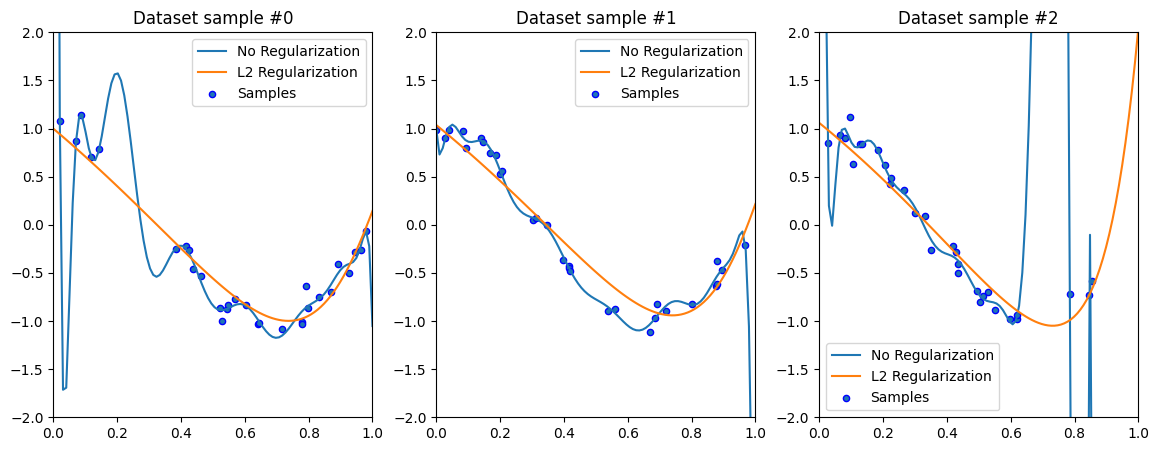

In [10]:
from sklearn.linear_model import Ridge

degrees = [15, 15, 15]
plt.figure(figsize=(14, 5))
for idx, i in enumerate(range(len(degrees))):
    # sample a dataset
    np.random.seed(idx)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = true_fn(X) + np.random.randn(n_samples) * 0.1

    # fit a least squares model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    
    # fit a Ridge model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = Ridge(alpha=0.1) # sklearn uses alpha instead of lambda
    pipeline2 = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline2.fit(X[:, np.newaxis], y)    

    # visualize results
    ax = plt.subplot(1, len(degrees), i + 1)
    # ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="No Regularization")
    ax.plot(X_test, pipeline2.predict(X_test[:, np.newaxis]), label="L2 Regularization")    
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Dataset sample #{}".format(idx))

It's an empirical fact that in order to define a very irregular function, we need very large polynomial weights.

Forcing the model to use small weights prevents it from learning irregular functions.

In [11]:
print('Non-regularized weights of the polynomial model need to be large to fit every point:')
print(pipeline.named_steps['lr'].coef_[:4])
print()

print('By regularizing the weights to be small, we force the curve to be more regular:')
print(pipeline2.named_steps['lr'].coef_[:4])

Non-regularized weights of the polynomial model need to be large to fit every point:
[-3.02370887e+03  1.16528860e+05 -2.44724185e+06  3.20288837e+07]

By regularizing the weights to be small, we force the curve to be more regular:
[-2.70114811 -1.20575056 -0.09210716  0.44301292]


In the above example, the weights of the best-fit degree 15 polynomial are huge: they are on the order of $10^3$ to $10^7$. By regularizing the model, we are forcing the weights to be small---less than $10^0$ in this example, As expected, a polynomial with small weights cannot reproduce the highly "wiggly" shape of the overfitting polynomial, and thus does not suffer from the same failure mode.

### How to Choose $\lambda$? (hyperparameter search)

Note that regularization has introduced a new parameter into our model---the regularization strength $\lambda$.

We refer to $\lambda$ as a __hyperparameter__, because it's a high-level parameter that controls other parameters.
Higher values of $\lambda$ induce a small norm for $\theta$. 

Note that we cannot learn $\lambda$ from data---if we did, the optimizer would just set it to zero to get the best possible training fit. This is also what makes it very distinct from regular parameters.

How do we choose $\lambda$ then? We select the $\lambda$ that yields the best model performance on the development set. Thus, we are in a sense choosing $\lambda$ by minimizing the training loss on the development set.

Over time this can lead us to overfit the development set; however, there is usually only a very small number of hyperparameters, and the problem is not as pronounced as regular overfitting.

## Normal Equations for L2-Regularized Linear Models

How, do we fit regularized models? As in the linear case, we can do this easily by deriving generalized normal equations! 

Let $L(\theta) = \frac{1}{2} (X \theta - y)^\top  (X \theta - y)$ be our least squares objective. We can write the L2-regularized objective as:
$$ J(\theta) = \frac{1}{2} (X \theta - y)^\top  (X \theta - y) + \frac{1}{2} \lambda ||\theta||_2^2 $$

This allows us to derive the gradient as follows:
\begin{align*}
\nabla_\theta J(\theta) 
& = \nabla_\theta \left( \frac{1}{2} (X \theta - y)^\top  (X \theta - y) + \frac{1}{2} \lambda ||\theta||_2^2 \right) \\
& = \nabla_\theta \left( L(\theta) + \frac{1}{2} \lambda \theta^\top \theta \right) \\
& = \nabla_\theta L(\theta) + \lambda \theta \\
& = (X^\top X) \theta - X^\top y + \lambda \theta \\
& = (X^\top X + \lambda I) \theta - X^\top y
\end{align*}

We used the derivation of the normal equations for least squares to obtain $\nabla_\theta L(\theta)$ as well as the fact that: $\nabla_x x^\top x = 2 x$.

We can set the gradient to zero to obtain normal equations for the Ridge model:
$$ (X^\top X + \lambda I) \theta = X^\top y. $$

Hence, the value $\theta^*$ that minimizes this objective is given by:
$$ \theta^* = (X^\top X + \lambda I)^{-1} X^\top y.$$

Note that the matrix $(X^\top X + \lambda I)$ is always invertible, which addresses a problem with least squares that we saw earlier.

## Summary: Algorithm: Ridge Regression

These derivations yield a new algorithm, which is known as L2-regularized ordinary least squares or simply *Ridge regression*.

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: L2-regularized mean squared error
* __Optimizer__: Normal equations

Ridge regression can be used to fit models with highly non-linear features (like high-dimensional polynomial regression), while keeping overfitting under control.

# Part 4: L1 Regularization and Sparsity

The L2 norm is not the only type of regularizer that can be used to mitigate overfitting. We will now look at another approach called L1 regularization, which will have an important new property called sparsity.

## L1 Regularization

### Definition

Another closely related approach to L2 regularization is to penalize the size of the weights using the L1 norm.

In the context of linear models $f(x) = \theta^\top x$, L1 regularization yields the following objective:
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \lambda \cdot ||\theta||_1. $$

Let's dissect the components of this objective.

* As before, the objective contains a supervised loss $L$ and a hyper-parameter $\lambda$.

* The regularizer $R : \mathcal{M} \to \mathbb{R}$ is now
$R(\theta) = ||\theta||_1 = \sum_{j=1}^d |\theta_j|.$ 
This is known as the L1 norm of $\theta$.

* This regularizer also penalizes large weights. However, it additionally forces most weights to decay to zero, as opposed to just being small.

### Algorithm: Lasso

L1-regularized linear regression is also known as the LASSO (Least Absolute Shrinkage and Selection Operator).

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: L1-regularized mean squared error

* __Optimizer__: gradient descent, coordinate descent, others, 

Unlike Ridge regression, the Lasso does not have an analytical formula for the best-fit parameters. In practice, we resort to iterative numerical algorithms, including variations of gradient descent and more specialized procedures.

## Sparsity

Like L2 regularization, the L1 approach makes model weights small. However, it doesn't just make the weights small---it sets some of them exactly zero. This property of the weights is called *sparsity*, and can be very useful in practice.

### 4.1 Definition

More formally, a vector is said to be sparse if a large fraction of its entires is zero. Thus, L1-regularized linear regression produces *sparse parameters* $\theta$.

Why is sparsity useful?

* It makes the model more interpretable. If we have a large number of features, the Lasso will set most of their parameters zero, thus effectively excluding them. This allows us to focus our attention on a small number of relevant features.
* Sparsity can also make models computationally more tractable. Once the model has set certain weights to zero---we can ignore their corresponding features entirely. This avoids us from spending and computation or memory on these features.

### 4.2 Visualizing Weights in Ridge and Lasso

To better understand sparsity, we fit Ridge and Lasso on the UCI diabetes dataset and observe the magnitude of each weight (colored lines) as a function of the regularization parameter.

Below is Ridge---each colored line represents the magnitude of each of the ten different model parameters as a function of regularization strength. Clearly, the weights become smaller as we regularize more.

(4.466835921509635e-06,
 223.872113856834,
 -868.3959639911257,
 828.0470310056076)

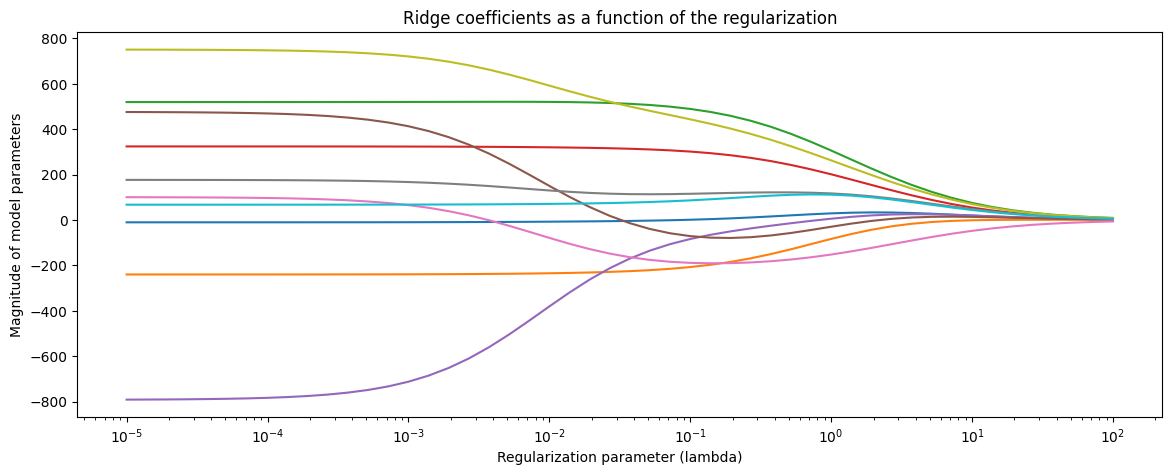

In [12]:
# based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

X, y = load_diabetes(return_X_y=True)

# create ridge coefficients
alphas = np.logspace(-5, 2,  )
ridge_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Regularization parameter (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

However, the Ridge model does not produce sparse weights---the weights are never exactly zero. Let's now compare it to a Lasso model.

(-132.9765140593514, 3672.998881621874, -869.3481054580192, 828.4461664627265)

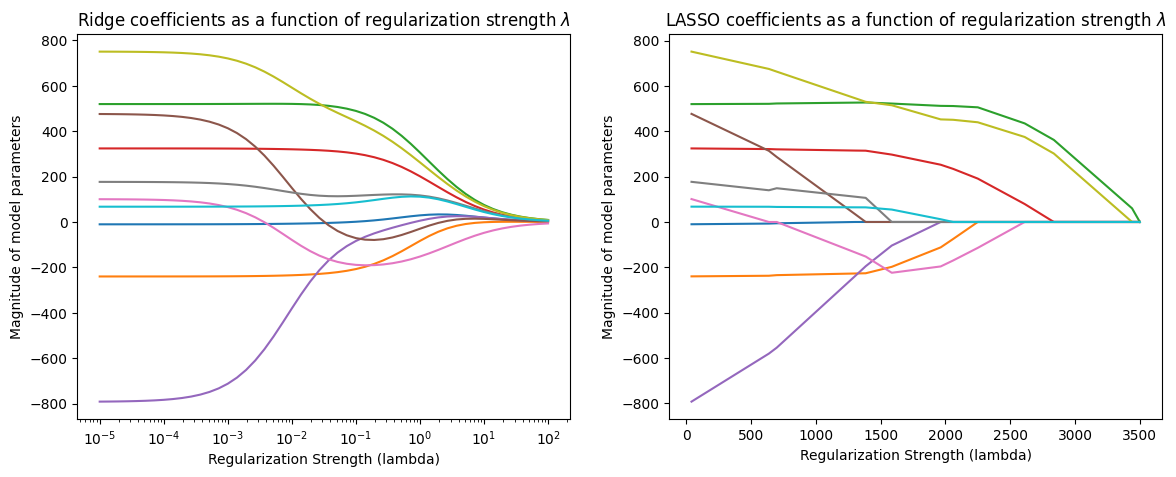

In [13]:
# Based on: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_diabetes
from sklearn.linear_model import lars_path

# create lasso coefficients    
X, y = load_diabetes(return_X_y=True)
_, _, lasso_coefs = lars_path(X, y, method='lasso')
xx = np.sum(np.abs(lasso_coefs.T), axis=1)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.subplot(121)    
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Regularization Strength (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Ridge coefficients as a function of regularization strength $\lambda$')
plt.axis('tight')

# plot lasso coefficients
plt.subplot(122) 
plt.plot(3500-xx, lasso_coefs.T)
ymin, ymax = plt.ylim()
plt.ylabel('Magnitude of model parameters')
plt.xlabel('Regularization Strength (lambda)')
plt.title('LASSO coefficients as a function of regularization strength $\lambda$')
plt.axis('tight')

Observe how the Lasso parameters become progressively smaller, until they reach exactly zero, and then they stay at zero.

## Why Does L1 Regularization Produce Sparsity?

We conclude with some intuition for why L1 regularization induces sparsity. This is a more advanced topic that is not essential for understanding the most important ideas in this section.

### Regularizing via Constraints

Consider a regularized problem with a penalty term:
$$ \min_{\theta \in \Theta} L(\theta) + \lambda \cdot R(\theta). $$

Alternatively, we may enforce an explicit constraint on the complexity of the model:
\begin{align*}
\min_{\theta \in \Theta} \; & L(\theta) \\
\text{such that } \; & R(\theta) \leq \lambda'
\end{align*}

We will not prove this, but solving this problem is equivalent to solving the penalized problem for some $\lambda > 0$ that's different from $\lambda'$. In other words, 
* We can regularize by explicitly enforcing $R(\theta)$ to be less than a value instead of penalizing it.
* For each value of $\lambda$, we are implicitly setting a constraint of $R(\theta)$.

#### An Example

This is what constraint-based regularization looks like for the linear models we have seen thus far:
\begin{align*}
\min_{\theta \in \Theta} \; & \frac{1}{2n} \sum_{i=1}^n \left( y^{(i)} - \theta^\top x^{(i)} \right)^2 \\
\text{such that } \; & ||\theta|| \leq \lambda'
\end{align*}

where $||\cdot||$ can either be the L1 or L2 norm.

### 4.3 Sparsity in L1 vs. L2 Regularization

The following image by <a href="https://medium.com/uwaterloo-voice/a-deep-dive-into-regularization-eec8ab648bce">Divakar Kapil</a> and Hastie et al. explains the difference between the two norms.

<left><img width=75% src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*lFnKhQwmxt8XvP4wTYYJbw.png"></left>

Lasso: $\beta_1+\beta_2 \leq \lambda'$ $\;\;\;\;\;\;\;\;$ Ridge: $\beta_1^2+\beta_2^2 \leq \lambda'$

The ellipses represent the level curves of the mean squared error (MSE) loss function used by both Ridge and Lasso. The unregularized minimizer is indicated by a black dot ($\hat\beta$).

However, the loss is regularized, and the parameters are constrained to live in the light blue regions. These are the L1 ball around zero (on the left) and the L2 ball around zero (on the right). Therefore, the parameters chosen by both models are point with the smallest MSE loss that are within the light blue feasible region.

In order to find these points, we have to find the level curve that is tangent to the feasible region (this is show in the figure). On the right hand side, the shape of the L2 feasible region is round ($\beta_1^2+\beta_2^2 \leq \lambda'$) and it's unlikely that the tanget point will be one that is sparse.

However, in the L1 case, the level curve will most likely be tangent to the L1 feasible region at a "vertex" of the diamond ($\beta_1+\beta_2 \leq \lambda'$). These "vertices" are aligned with the axes---therefore at these points some of the coefficients are exactly zero. This is the intuition for why L1 produces sparse parameter vectors.